In [1]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
np.set_printoptions(precision=5, suppress=True, linewidth=100)
plt.rcParams['figure.dpi'] = 150
from scipy.io import savemat
from tenpy.tools.params import get_parameter
from matplotlib import colors
import matplotlib.pyplot as plt
import sys
from tenpy.models.mixed_xk import MixedXKLattice

/Users/gleb/TeNPy/tenpy/tools/optimization.py:307: UserWarning: Couldn't load compiled cython code. Code will run a bit slower.
  warnings.warn("Couldn't load compiled cython code. Code will run a bit slower.")


In [2]:
import tenpy
import tenpy.linalg.np_conserved as npc
from tenpy.algorithms import dmrg
from tenpy.networks.mps import MPS
from tenpy.models.tf_ising import TFIChain
tenpy.tools.misc.setup_logging(to_stdout="INFO")
import pickle
from tenpy.tools.misc import to_array, inverse_permutation, to_iterable

In [3]:
from tenpy.networks.mps import MPS
from tenpy.models.tf_ising import TFIChain
from tenpy.algorithms import dmrg
from tenpy.networks.site import SpinSite, SpinHalfSite, SpinHalfFermionSite, FermionSite
from tenpy.models.lattice import Triangular, Square
from tenpy.models.model import CouplingModel, NearestNeighborModel, MPOModel

# Spinless mixed model, N-conserved, ky - not conserved

In [4]:
class Hubbard_mixed(CouplingModel, MPOModel):
    def __init__(self, model_param):
        
        ''' system size '''
        Lx = model_param["Lx"]
        Ly = model_param["Ly"]
#         Lx = q 
        
        ''' coupling constants'''
        t = model_param["t"]
        V = model_param["V"]
#         phi = model_param["phase"]
        
        
        ''' boundary conditions'''
        bc_MPS = model_param["bc_MPS"]
        bc_y = model_param["bc_y"]
        bc_x = model_param["bc_x"]
        
        
        ''' site with particle + U(1) symmetry conservation'''
        site = FermionSite(conserve='N', filling = 0.5)
        
        ''' define square lattice'''
        lat = Square(Lx, Ly, site, bc=[bc_x, bc_y], bc_MPS=bc_MPS)   
        

        CouplingModel.__init__(self, lat)
        
        dR1 = [1,0]
        
        if model_param["flux"]:
            
            '''hopping terms'''
            hops_along_x = (-t) * np.array([-1j + (-1) * np.exp(-1j * 2 * np.pi/Ly * np.arange(Ly)), -1j + np.exp(-1j * 2 * np.pi/Ly * np.arange(Ly))])
            hops_y = (-t) * np.array([2 * np.cos(2 * np.pi/Ly * np.arange(Ly)), - 2 * np.cos(2 * np.pi/Ly * np.arange(Ly))])
            
            self.add_coupling(hops_along_x, 0, 'Cd', 0,'C', dR1, plus_hc=True)
            self.add_onsite(hops_y, 0, 'N')
         
        else:
            
            '''hopping terms'''
            hops_along_x = (-t) * np.array([1 + (+1) * np.exp(-1j * 2 * np.pi/Ly * np.arange(Ly))])
#             hops_along_x = (-t)
            hops_y = (-t) * np.array([2 * np.cos(2 * np.pi/Ly * np.arange(Ly))])
            self.add_coupling(hops_along_x, 0, 'Cd', 0,'C', dR1, plus_hc=True)
            self.add_onsite(hops_y, 0, 'N')
        
        ''' density-density interaction'''
        for q1 in range(Ly):
            for q2 in range(Ly):
                dx1 = [0, q1]
                dx2 = [0, 0]
                dx4 = [0, q2]
                dx3 = [0, q2 - q1]

                self.add_multi_coupling(V/Ly, [('Cd', [0,q1], 0), ('C', [0,0], 0), ('Cd', [1,q2-q1], 0), ('C', [1,q2], 0)])
                self.add_multi_coupling(np.exp(-1j * 2 * np.pi/Ly * q1) * V/Ly, [('Cd', [0,q1], 0), ('C', [0,0], 0), ('Cd', [1,q2-q1], 0), ('C', [1,q2], 0)])

                if q1 == 0 and q2 == 0:
                    dd_interaction = V/Ly
                    self.add_onsite(dd_interaction, 0, 'N')

                else:
                    self.add_multi_coupling(np.cos(2 * np.pi/Ly * q1) * V/Ly, [('Cd', dx1, 0), ('C', dx2, 0), ('Cd', dx3, 0), ('C', dx4, 0)])                    
        
        MPOModel.__init__(self, lat, self.calc_H_MPO())
#         ax = plt.gca()
#         lat.plot_basis(ax)

# Define DRMG parameters

In [5]:
# if flux = True, Lx = 2
# if flux = False, Lx = 1

model_param = {"Lattice" : Square,
              "Ly" : 3,
              "Lx" : 3,
              "t" : 1.0,
              "V" : 15.0,
              "fraction" : 2,
              "bc_MPS" : "infinite",
              "bc_y" : 'periodic',
              "bc_x" : 'periodic',
              "flux" : False}

# chi_list = tenpy.algorithms.dmrg.chi_list(500, dchi=200, nsweeps=20)
chi_list = {0:200, 20:400, 40:800}
dmrg_params = {"trunc_params": {"chi_max": 1000, "svd_min": 1.e-10}, "mixer": True, "chi_list" : chi_list,"max_sweeps": 100}

# Configure DMRG model and initial state

In [6]:
M = Hubbard_mixed(model_param)
sites = M.lat.mps_sites()
psi = MPS.from_product_state(sites,["full","empty","empty","full","empty","empty", "full","empty","empty"],"infinite")

In [7]:
info = dmrg.run(psi, M, dmrg_params)
energy = info['E']
delta_energy = abs(info["sweep_statistics"]['E'][-1] - info["sweep_statistics"]['E'][-2])

INFO    : DMRG: subconfig 'trunc_params'=Config(<2 options>, 'trunc_params')
INFO    : DMRG: reading 'chi_list'={0: 200, 20: 400, 40: 800}
INFO    : start environment_sweep
INFO    : trunc_params: reading 'chi_max'=1000
INFO    : trunc_params: reading 'svd_min'=1e-10
INFO    : DMRG: reading 'max_sweeps'=100
INFO    : DMRG: reading 'mixer'=True
INFO    : activate DensityMatrixMixer with initial amplitude 1.0e-05
INFO    : Running sweep with optimization
INFO    : activate DensityMatrixMixer with initial amplitude 1.0e-05
INFO    : Setting chi_max=200
INFO    : start environment_sweep
INFO    : checkpoint after sweep 10
energy=-0.0713927424155859, max S=0.6660840543943646, age=297, norm_err=1.7e-12
Current memory usage 234128.0MB, wall time: 118.2s
Delta E = nan, Delta S = 4.4445e-02 (per sweep)
max trunc_err = 2.0493e-18, max E_trunc = 1.1369e-13
chi: [190, 200, 97, 168, 173, 189, 191, 178, 157]
INFO    : Running sweep with optimization
INFO    : disable mixer after 15 sweeps, final amp

In [8]:
corr_length = psi.correlation_length()

# Compute correlation function

In [9]:
dist = np.arange(0, 40)
Ly = 3
charge_corr = np.zeros(len(dist))

In [10]:
for j,d in enumerate(dist):
#     print(j, d)
    x_d = d // Ly
    y_d = d % Ly
    print(x_d, y_d)
    for k in range(Ly):
        for l in range(Ly):
            for p in range(Ly):
                for q in range(Ly):
#                         print(k,l,p,q)
#                         print(np.exp(1j * 2 * np.pi/Ly * (k - l + p - q)) * \
#                         psi.expectation_value(ops=["Cd","C","Cd","C"], sites=[0 * Ly + k, 0 * Ly + l, x * Ly + p, x * Ly + q]))
#                         charge_corr[j]+=np.exp(1j * 2 * np.pi/Ly * (k - l + p - q)) * \
#                         psi.expectation_value(ops=["Cd","C","Cd","C"], sites=[0 * Ly + k, 0 * Ly + l, x * Ly + p, x * Ly + q])

                    charge_corr[j]+=np.exp(1j * 2 * np.pi/(Ly) * (0 * (k - l) + y_d * (p - q))) * psi.expectation_value_term([('Cd', k), ('C', l), ('Cd', x_d * Ly + p), ('C', x_d * Ly + q)])

0 0
  charge_corr[j]+=np.exp(1j * 2 * np.pi/(Ly) * (1 * (k - l) + (y_d + 1) * (p - q))) * psi.expectation_value_term([('Cd', k), ('C', l), ('Cd', x_d * Ly + p), ('C', x_d * Ly + q)])

0 1
0 2
1 0
1 1
1 2
2 0
2 1
2 2
3 0
3 1
3 2
4 0
4 1
4 2
5 0
5 1
5 2
6 0
6 1


Text(0.5, 1.0, 'Conserve ky, V = 15, corr_length = 1.0945433824775161')

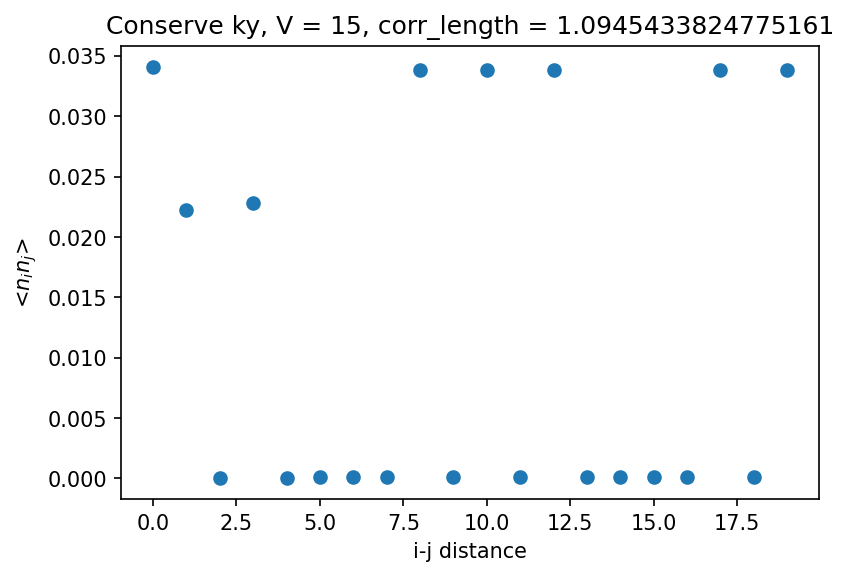

In [11]:
plt.figure()
plt.scatter(dist, charge_corr)
# plt.ylim([0, 0.4])
plt.xlabel('i-j distance')
plt.ylabel('<$n_i n_j$>')   
plt.title("Conserve ky, V = 15, corr_length = " + str(corr_length))
# plt.savefig("flux_mixed_conserved_Ly_3_Lx_2_half_filling_2.pdf")